### Student Information
Name: Lee Huai

Student ID: 111065524

GitHub ID: chihuahualee828

Kaggle name: 一条吉

Kaggle private scoreboard snapshot:
[Snapshot](img/pic0.png)
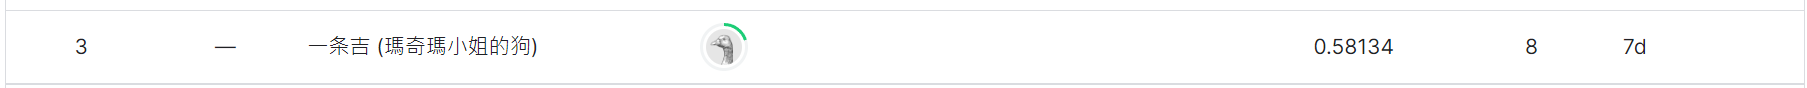

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the DM2023-Lab2-master. You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2) regarding Emotion Recognition on Twitter by this link https://www.kaggle.com/t/09b1d0f3f8584d06848252277cb535f2. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Dec. 27th 11:59 pm, Wednesday)_. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 31th 11:59 pm, Sunday)__. 

In [1]:
### Begin Assignment Here

=============================================================================================================
# 3. Kaggle Report:

### 1. First, read csv and json files and preprocessing:

In [2]:
import pandas as pd
import json
from pathlib import Path
from datetime import datetime
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
iden_df = pd.read_csv("../data/kaggle/data_identification.csv",
                         header=0)
emotion_df = pd.read_csv("../data/kaggle/emotion.csv",
                         header=0)
print(len(iden_df), len(emotion_df))

1867535 1455563


In [4]:
# Load the tweets json raw data file
with open("../data/kaggle/tweets_DM.json", "r") as file:
    tweets_data = [json.loads(line) for line in file]

len(tweets_data)

1867535

In [5]:
# convert json files into pandas dataframe, with tweet_id, hashtags, and text columns
tweets_info = []
for tweet in tweets_data:
    tweet_id = tweet["_source"]["tweet"]["tweet_id"]
    hashtags = tweet["_source"]["tweet"]["hashtags"]
    text = tweet["_source"]["tweet"]["text"]
    tweets_info.append({"tweet_id": tweet_id, "hashtags": hashtags, "text": text})

# Create a dataframe from the tweets information
tweets_df = pd.DataFrame(tweets_info)
tweets_df.head()


,tweet_id,hashtags,text
0,0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,[bibleverse],"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,[],"""Trust is not the same as faith. A friend is s..."


In [6]:
# Split into train and test dataframes based on identification file
merged_df = pd.merge(iden_df, tweets_df, on="tweet_id")

train_df = merged_df[merged_df["identification"] == "train"]
test_df = merged_df[merged_df["identification"] == "test"]

# concat train_df with its ground truth emotion
train_df = pd.merge(train_df, emotion_df, on="tweet_id")

print(train_df.head())
print(len(train_df))

print(test_df.head())
print(len(test_df))

   tweet_id identification                                           hashtags  \
0  0x29e452          train                                                 []   
1  0x2b3819          train                                  [spateradio, app]   
2  0x2a2acc          train                                                 []   
3  0x2a8830          train  [PUBG, GamersUnite, twitch, BeHealthy, StayPos...   
4  0x20b21d          train                             [strength, bones, God]   

                                                text       emotion  
0  Huge Respect🖒 @JohnnyVegasReal talking about l...           joy  
1  Yoooo we hit all our monthly goals with the ne...           joy  
2  @KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...         trust  
3  Come join @ambushman27 on #PUBG while he striv...           joy  
4  @fanshixieen2014 Blessings!My #strength little...  anticipation  
1455563
    tweet_id identification          hashtags  \
0   0x28cc61           test               

In [7]:
# utilize dmh functions from hw1
import sys
sys.path.append('../helpers')
import data_mining_helpers as dmh

##### Check if any missing datas:

In [8]:
train_df.isnull().apply(lambda x: dmh.check_missing_values(x))

,tweet_id,identification,hashtags,text,emotion
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0,0,0


In [9]:
test_df.isnull().apply(lambda x: dmh.check_missing_values(x))

,tweet_id,identification,hashtags,text
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0,0


# We finetune Roberta for our task:
##### The reason we choose to finetune Roberta for sentiment classification is because Roberta is pretrained on Twitter datas and do consider emojis, and it has been shown to be effective in task like sentiment classification, we use RobertaForSequenceClassification and finetune it with our own tweets data and labels since we have different labels(8 sentiments) than default(positive, neutral and negative):

In [25]:
import torch
from transformers import RobertaTokenizer, RobertaTokenizerFast, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import pickle

In [11]:
target_list = ['anger', 'anticipation', 'disgust', 'fear', 'sadness', 'surprise', 'trust', 'joy']

##### We use pretrained Roberta-large for best performance and tokenize the tweets first:
##### This step can take quite a while and take up some memory, we can save the encoded datas into pkl files:

In [12]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-large')
# we can use roberta-base and reduce max length to reduce the memory usage:
encoded_data = tokenizer(list(train_df['text']), truncation=True, padding=True, return_tensors='pt', max_length=256)

##### Let's see what the tokenized datas look llike:

In [13]:
input_ids = encoded_data['input_ids'][0]

# Decode the token IDs to obtain the original sentence
decoded_sentence = tokenizer.decode(input_ids, skip_special_tokens=True)

# Print the results
print("Original Sentence:", train_df['text'].iloc[0])
print("Tokenized Sentence:", decoded_sentence)

decoded_tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(decoded_tokens)
print(len(decoded_tokens))
# Print each token along with its token ID
for token, token_id in zip(decoded_tokens, input_ids):
    print(f"Token: {token}\tToken ID: {token_id}")

Original Sentence: Huge Respect🖒 @JohnnyVegasReal talking about losing his dad to cancer."if you dont remember the good times it was all for nothing"#beautiful
Tokenized Sentence: Huge Respect🖒 @JohnnyVegasReal talking about losing his dad to cancer."if you dont remember the good times it was all for nothing"#beautiful
['<s>', 'H', 'uge', 'ĠRespect', 'ðŁ', 'ĸ', 'Ĵ', 'Ġ@', 'Johnny', 'V', 'eg', 'as', 'Real', 'Ġtalking', 'Ġabout', 'Ġlosing', 'Ġhis', 'Ġdad', 'Ġto', 'Ġcancer', '."', 'if', 'Ġyou', 'Ġdont', 'Ġremember', 'Ġthe', 'Ġgood', 'Ġtimes', 'Ġit', 'Ġwas', 'Ġall', 'Ġfor', 'Ġnothing', '"', '#', 'beaut', 'iful', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'

##### Roberta uses BPE tokenizer, each unique token is mapped to Roberta predefined token ID, we have total of 1455563 sentences, each has its sentence tokenized and token ids, forming a 1455563x256 sized tensor

In [14]:
print(encoded_data['input_ids'].size())

torch.Size([1455563, 256])


##### Attention mask indicates where the token is inside the 256 tokens.

In [15]:
print(encoded_data['input_ids'][:10])
print(encoded_data['attention_mask'][:10])
unique_elements = torch.unique(encoded_data['input_ids'])
num_unique_elements = unique_elements.numel()
num_unique_elements

tensor([[    0,   725, 11797,  ...,     1,     1,     1],
        [    0,   975, 40386,  ...,     1,     1,     1],
        [    0,  1039,   530,  ...,     1,     1,     1],
        ...,
        [    0,  1039, 33049,  ...,     1,     1,     1],
        [    0,   100,    64,  ...,     1,     1,     1],
        [    0, 10431, 11621,  ...,     1,     1,     1]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


48804

##### Roberta can encode and decode emojis properly so it should theoretically be effective in sentiment classification task:

In [16]:
tokenizer.decode(tokenizer.encode("😂"))

'<s>😂</s>'

In [17]:
label_map = {label: i for i, label in enumerate(target_list)}
label_map

{'anger': 0,
 'anticipation': 1,
 'disgust': 2,
 'fear': 3,
 'sadness': 4,
 'surprise': 5,
 'trust': 6,
 'joy': 7}

In [18]:
# Map emotion labels to each tweet's tensor
label_map = {label: i for i, label in enumerate(target_list)}
encoded_data['labels'] = torch.tensor([label_map[label] for label in train_df['emotion']])
print(encoded_data['labels'][:10])
print(encoded_data['labels'].size())

# # one-hot encoding
# one_hot_labels = torch.zeros((len(encoded_data['input_ids']), len(target_list)))

# # Iterate through the DataFrame and set the corresponding elements to 1
# for i, label in enumerate(encoded_data['labels']):
#     one_hot_labels[i, label] = 1
# encoded_data['labels'] = one_hot_labels


tensor([7, 7, 6, 7, 1, 1, 1, 7, 4, 6])
torch.Size([1455563])


In [19]:
print(train_df['text'].iloc[1])
print(train_df['emotion'].iloc[1])

Yoooo we hit all our monthly goals with the new app in two weeks. #spateradio #app <LH>
joy


##### We use single_label_classification since each tweet only has one target emotion in our case, and it uses cross-entropy as loss, multi_label_classification can be used if we want to predict multiple sentiments for sentences:

In [20]:
model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=len(label_map), problem_type = 'single_label_classification')

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### We can see our model structure, its output is a 8 number logits tensor:

In [21]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [22]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

# Training:
##### Here we define our pytorch trainer, since we are using Roberta-large and our dataset is large, it will take quite a while to train, about 2 hours for 1 epoch using RTX 4090, so you can just load our trained model with best result in "./runs/test_pred_large_full_epoch5_lr3e-6_bs16/training_result/model.pth" in the block below testing:

In [50]:
class Trainer:
    def __init__(self, log_dir, model, encoded_data):
        '''Initialize the varibles for training
        Args:
            log_dir: (pathlib.Path) the direction used for logging
        '''
        self.log_dir = log_dir
        print(self.log_dir)
        # Split into train and valid, 8:2
        self.train_inputs, self.validation_inputs, self.train_attentions, self.validation_attentions, self.train_labels, self.validation_labels = train_test_split(encoded_data['input_ids'],
                                                                                            encoded_data['attention_mask'],
                                                                                            encoded_data['labels'],
                                                                                            random_state=42,
                                                                                            test_size=0.2)
        self.batch_size = 16
        self.train_dataset = TensorDataset(self.train_inputs, self.train_attentions, self.train_labels)
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
        self.validation_dataset = TensorDataset(self.validation_inputs, self.validation_attentions, self.validation_labels)
        self.valid_loader = DataLoader(self.validation_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

        print(len(self.train_dataset))


        # model, loss function, optimizer
        self.device = 'cuda'
        self.model = model.to(self.device)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.lr = 5e-6
        self.optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
        self.lr_decay = 0.5
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, 1, gamma=self.lr_decay, last_epoch=-1, verbose=False)
        # self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', verbose=True)
        self.max_epoch = 8

    def run(self):
        training_result_dir = self.log_dir / 'training_result'
        training_result_dir.mkdir(parents=True)
        metrics = {'train_loss': [], 'valid_loss': []}
        lrs = []
        for self.epoch in range(self.max_epoch): # epochs
            train_loss = self.train() # train 1 epoch
            valid_loss = self.valid() # valid 1 epoch
            print('lr:',get_lr(self.optimizer))
            lrs.append(get_lr(self.optimizer))
            print(f'Epoch {self.epoch:03d}:')
            print('train loss:', train_loss)
            print('valid loss:', valid_loss)
            metrics['train_loss'].append(train_loss)
            metrics['valid_loss'].append(valid_loss)
            # Save the parameters(weights) of the model to disk
            if torch.tensor(metrics['valid_loss']).argmin() == self.epoch:
                torch.save(self.model.state_dict(), str(training_result_dir / 'model.pth'))
        
        # Plot the loss curve against epoch
        fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
        ax.set_title(f'Loss(batch_size:{self.batch_size}, lr:{self.lr}, lr_decay:{self.lr_decay if self.lr_decay else "False"})')
        ax.plot(range(self.epoch + 1), metrics['train_loss'], label='Train')
        ax.plot(range(self.epoch + 1), metrics['valid_loss'], label='Valid')
        ax.legend()
        plt.show()
        fig.savefig(str(training_result_dir / 'metrics.jpg'))
        plt.close()


    def train(self):
        '''Train one epoch
        1. Switch model to training mode
        2. Iterate mini-batches and do:
            a. clear gradient
            b. forward to get loss
            c. loss backward
            d. update parameters
        3. Return the average loss in this epoch
        '''
        self.model.train()
        loss_steps = []

        for batch_inputs, batch_attentions, batch_labels in tqdm(self.train_loader):
            batch_inputs, batch_attentions, batch_labels = batch_inputs.to(self.device), batch_attentions.to(self.device), batch_labels.to(self.device)
            # Forward pass
            outputs = model(input_ids=batch_inputs, attention_mask=batch_attentions ,labels=batch_labels)
            loss = outputs.loss
            # print(outputs.logits)
            # predictions = torch.nn.functional.softmax(outputs.logits, dim=1)
            # print(predictions)
            # predictions = torch.argmax(predictions, dim=1)
            # print(batch_labels, predictions)
            # print(loss)
            # Backward pass and optimization
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            loss_steps.append(loss.detach().item())
            # total_loss += loss.item()
            # self.scheduler.step()
        
        # Calculate average training loss for the epoch
        avg_train_loss = sum(loss_steps) / len(self.train_loader)
        print(f"Epoch {self.epoch + 1}, Avg. Training Loss: {avg_train_loss:.4f}")
        
        return avg_train_loss

    @torch.no_grad()
    def valid(self):
        '''Validate one epoch
        1. Switch model to evaluation mode and turn off gradient (by @torch.no_grad() or with torch.no_grad())
        2. Iterate mini-batches and do forwarding to get loss
        3. Return average loss in this epoch
        '''
        self.model.eval()
        loss_steps = []
        all_predictions = []
        all_true_labels = []

        for batch_inputs, batch_attentions, batch_labels in self.valid_loader:
            batch_inputs, batch_attentions, batch_labels = batch_inputs.to(self.device), batch_attentions.to(self.device), batch_labels.to(self.device)
            # Forward pass
            outputs = self.model(input_ids=batch_inputs, attention_mask=batch_attentions)
            predictions = outputs.logits.cpu()
            # predictions = torch.nn.functional.softmax(outputs.logits).cpu()
            # predictions = torch.argmax(predictions, dim=1).cpu().numpy()
            true_labels = batch_labels.cpu()
            # print(predictions, true_labels)
            loss_steps.append(self.criterion(predictions, true_labels))
            true_labels = true_labels.numpy()
            all_predictions.extend(predictions)
            all_true_labels.extend(true_labels)

            

        # Calculate accuracy on the validation set
        avg_valid_loss = sum(loss_steps) / len(self.valid_loader)
        print(f"Epoch {self.epoch + 1}, Validation Accuracy: {avg_valid_loss:.4f}")
        return avg_valid_loss

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


log_dir = Path('./runs/') / f'{datetime.now():%b%d_%H_%M_%S}'
log_dir.mkdir(parents=True, exist_ok=True)
model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=len(label_map), problem_type = 'single_label_classification')
Trainer(log_dir, model, encoded_data).run()

# Testing:
##### Here we load our testing dataset, tokennize it and create the dataloader:

In [23]:
test_encoded_data = tokenizer(list(test_df['text']), truncation=True, padding=True, return_tensors='pt', max_length=256)

class CustomTestDataset(TensorDataset):
    def __init__(self, tweet_ids, input_ids, attention_mask):
        super(CustomTestDataset, self).__init__(input_ids,attention_mask)
        self.tweet_ids = tweet_ids

    def __getitem__(self, index):
        # Return both input_ids tensor and tweet_id
        return (self.tweet_ids[index], super(CustomTestDataset, self).__getitem__(index))
    
test_dataset = CustomTestDataset(test_df["tweet_id"].values, test_encoded_data['input_ids'], test_encoded_data['attention_mask'])

# Create the data loader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(test_encoded_data['input_ids'].size())


torch.Size([411972, 218])


##### Load our trained weights into our model:

In [24]:
device = 'cuda'
model = model.to(device)
log_dir =  Path('./runs/') / 'test_pred_large_full_epoch5_lr3e-6_bs16'
model.load_state_dict(torch.load(str(log_dir / 'training_result/model.pth')))
# model.eval()
print(str(log_dir / 'training_result/model.pth'))

log_dir_test = Path('./testing_result') / f'{datetime.now():%b%d_%H_%M_%S}'
log_dir_test.mkdir(parents=True)
print(log_dir_test)

runs\test_pred_large_full_epoch5_lr3e-6_bs16\training_result\model.pth
testing_result\Dec30_20_16_39


In [54]:
model.state_dict()

OrderedDict([('roberta.embeddings.word_embeddings.weight',
              tensor([[-0.1387, -0.0081,  0.0375,  ...,  0.0505, -0.0072, -0.0370],
                      [ 0.0078, -0.0156,  0.0156,  ..., -0.0156,  0.0231,  0.0156],
                      [-0.0838, -0.0010, -0.1174,  ...,  0.1078,  0.0703, -0.0368],
                      ...,
                      [ 0.0393,  0.0031,  0.0465,  ..., -0.0240, -0.0505,  0.0342],
                      [ 0.0499,  0.0272,  0.0413,  ..., -0.0370, -0.0100,  0.0071],
                      [-0.0149, -0.0114, -0.0222,  ...,  0.0441,  0.0116, -0.0330]],
                     device='cuda:0')),
             ('roberta.embeddings.position_embeddings.weight',
              tensor([[-0.0038,  0.0253, -0.0092,  ...,  0.0177,  0.0062, -0.0162],
                      [ 0.0117, -0.0019, -0.0267,  ...,  0.0062, -0.0193,  0.0264],
                      [ 0.0335,  0.0164, -0.0565,  ..., -0.0720, -0.0473,  0.0459],
                      ...,
                      [-0.0

##### Testing model prediction using random sentence:

In [60]:
test = test_df['text'].iloc[4]
print(test)
test_encoded_data = tokenizer(test, truncation=True, padding=True, return_tensors='pt', max_length=256)
model.eval()
predictions = model(input_ids=test_encoded_data['input_ids'].cuda(), attention_mask=test_encoded_data['attention_mask'].cuda())
print(predictions)
predictions = torch.argmax(predictions.logits, dim=1)
print(target_list[predictions])


Felt like total dog 💩 going into open gym and had a migraine Played through and sweated it out and my sweat has never been that bad. <LH>
SequenceClassifierOutput(loss=None, logits=tensor([[-0.4467,  0.0569,  0.7836, -2.3658, -0.2151, -0.5494,  1.5402,  1.7775]],
       device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)
joy


# Inference:
##### Predict our testing dataset emotions and save it as csv:

In [ ]:
def test():
    model.eval()
    all_predictions = []
    all_tweet_ids = []
    for batch_inputs in tqdm(test_loader):
        tweet_ids = list(batch_inputs[0])
        # print(tweet_ids)
        batch_inputs[1][0] = batch_inputs[1][0].to(device)
        batch_inputs[1][1] = batch_inputs[1][1].to(device)
        # Forward pass
        outputs = model(input_ids=batch_inputs[1][0], attention_mask=batch_inputs[1][1])
        logits = outputs.logits
        predictions = torch.nn.functional.softmax(logits, dim=1)
        # print(predictions)
        predictions = torch.argmax(predictions, dim=1)
        predicted_labels = [target_list[idx] for idx in predictions]
        # print(predicted_labels)
        all_tweet_ids.extend(tweet_ids)
        all_predictions.extend(predicted_labels)

    
    predicted_dict = dict(zip(all_tweet_ids, all_predictions))
    # print(predicted_dict)
    return predicted_dict


with torch.no_grad():
    df_pred = test()
    print(df_pred)

In [ ]:
len(df_pred)

In [ ]:
unique_val_set = set(df_pred.values())
print(unique_val_set)

{'sadness', 'disgust', 'surprise', 'anticipation', 'trust', 'joy', 'anger', 'fear'}


##### Submission CSV file is stored in ./testing_result:

In [ ]:
result_df = pd.DataFrame(list(df_pred.items()))
print(len(result_df))
result_df.head()
result_df.columns = ['id', 'emotion']
result_df.reset_index(drop=True, inplace=True)
result_df.to_csv(str(log_dir_test / 'test_pred.csv'), index=False)